In [113]:
import numpy as np 
import glob, os, pickle, warnings
import pandas as pd
from util import read_pickle
from pathlib import Path
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold,  GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error,r2_score
warnings.filterwarnings(action='ignore',category=DeprecationWarning and FutureWarning)

### Directory List (summary with link)

### Spotify_query Class 
- See data_query.py

### Scrap MP3 from URL 
- See scrapMP3_fromURL.py

### Baseline Model Benchmarks

In [114]:
# get data 
genre = 'mandopop'
base_dir = Path('.')
data_dir = base_dir.joinpath("data")
fid = data_dir.joinpath(f'songs_{genre}.pkl')
song_dat = read_pickle(fid)


# start with general linear regression with regularization 
# tuned hyperparameter alpha with cv
def _pred_popularity(df, model):
    
    # set up cv
    kf = KFold(n_splits=5, shuffle = True) # 5 fold
    # standarize feature
    audio_fts = ['danceability', 'energy', 'loudness', 'speechiness',
                 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                 'duration_ms'] # feature names
    feature = df[audio_fts].to_numpy()
    scaler = StandardScaler().fit(feature)
    feature_standarized = scaler.transform(feature)
    label = df['popularity'].to_numpy()
    
    pred_acc_list = [] 
    mse_list = []
    for train_index, test_index in kf.split(df):
        
        train_feature, train_label = feature_standarized[train_index], label[train_index] # training feature and label
        test_feature, test_label = feature_standarized[test_index], label[test_index] # testing feature and label
 
        if model == 'linear':
            parameters = {'alpha':[0.1, 1, 10, 100, 1000]}
            clf = GridSearchCV(Ridge(), parameters, cv = 5)
        elif model == 'poly_kernel':
            #parameters = {'C':[0.1], 'epsilon': [0.1]}
            #clf = GridSearchCV(SVR(kernel='rbf'), parameters, cv = 3)
            clf = SVR(kernel='poly', degree = 3, C = 1, epsilon = 0.1)

        clf.fit(train_feature, train_label)
        pred_test_label = clf.predict(test_feature)
        
        pred_acc_list.append(spearmanr(test_label, pred_test_label)[0])
        mse_list.append(mean_squared_error(test_label, pred_test_label))
        
        mean_r = np.mean(pred_acc_list)
        mean_mse = np.mean(mse_list)
        
    return mean_r, mean_mse

def _debug_error_source(df_train, df_test, model):
    
    # df_train and df_test need to be standarized 
    audio_fts = ['danceability', 'energy', 'loudness', 'speechiness',
                 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                 'duration_ms']
    train_feature, train_label = df_train[audio_fts].to_numpy(), df_train['popularity'].to_numpy()
    test_feature, test_label = df_test[audio_fts].to_numpy(), df_test['popularity'].to_numpy()
    
    if model == 'linear':
        parameters = {'alpha':[0.1, 1, 10, 100, 1000]}
        clf = GridSearchCV(Ridge(), parameters, cv = 5)
    elif model == 'poly_kernel':
        #parameters = {'C':[0.1], 'epsilon': [0.1]}
        #clf = GridSearchCV(SVR(kernel='rbf'), parameters, cv = 3)
        clf = SVR(kernel='poly', degree = 2, C = 1, epsilon = 0.1)
    
    clf.fit(train_feature, train_label)
    pred_train_label = clf.predict(train_feature) # for computing training error
    pred_test_label = clf.predict(test_feature) # for computing testing error
    
    train_mse = mean_squared_error(train_label, pred_train_label)
    test_mse = mean_squared_error(test_label, pred_test_label)
    
    return train_mse, test_mse
    
linear_pred_acc_r, linear_pred_acc_mse = _pred_popularity(song_dat, 'linear')    

In [80]:
train_mse_list, test_mse_list = [], []
song_dat_shuffle = song_dat.copy(deep = True)

song_dat_shuffle = song_dat_shuffle.sample(frac=1, random_state = 1900).reset_index(drop=True)

for size in list(range(2000, len(song_dat)-2000, 2000)):
    
    training, testing = song_dat_shuffle.loc[0:size,], song_dat_shuffle.loc[len(song_dat)-2000:len(song_dat),]
    
    train_mse, test_mse = _debug_error_source(training, testing, 'linear')
    train_mse_list.append(train_mse)
    test_mse_list.append(test_mse)

<AxesSubplot:>

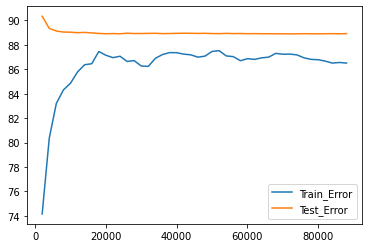

In [81]:
pd.DataFrame({"Train_Error":train_mse_list,
              "Test_Error":test_mse_list}, 
              index = list(range(2000, len(song_dat)-2000, 2000))).plot.line()

In [84]:
poly_pred_acc_r, poly_pred_acc_mse = _pred_popularity(song_dat, 'poly_kernel')  

In [85]:
poly_pred_acc_mse

102.80572563566434

In [7]:
import audioread
import librosa
import os, shutil, warnings, glob
import numpy as np
import numpy as np
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")


# Extract mel spectrum features at different hop length
def _extract_melspec(in_file, win_size):
    
    """
    In_file is a path pointing to a MP3 file
    output is of the shape (#Frame, #mel)
    """
    
    sig, sr = librosa.core.load(in_file, sr=16000)
    feat = librosa.feature.melspectrogram(sig, sr=16000,
                                          n_fft=win_size,
                                          hop_length=512,
                                          n_mels=128).T
    feat = np.log(1+10000*feat)
    return feat

# padding if sone less than 30s
def _append_zero_row(array, n_total_row):
    r, c = array.shape
    if r >= n_total_row:
        return array
    else:
        temp = np.zeros((n_total_row-r, c))
        return np.vstack([array, temp])
    

def _make_batch_feat(feature_list, length=939):
    
    """
    feature_list is the list of output of _extract_melspec, numpy array. 
    If only one song, need to make it into a list
    
    output file is of the shape (nSong, 1, nFrame, nMel)
    """
    
    feat = []
    a_array = []
    
    for idx, term in enumerate(feature_list):

        a_array = _append_zero_row(term, length)[None, None, :length, :].astype('float32')
        feat.append(a_array)

    feat = np.vstack(feat)
    return feat

def _standardize(batch_feat, scaler=None):
    
    k = batch_feat.shape[-1]
    n = batch_feat.shape[0]
    batch_feat = batch_feat.reshape((-1, k))
    
    scaler = StandardScaler().fit(batch_feat)
    batch_feat_s = scaler.transform(batch_feat)
    
    batch_feat_s = batch_feat_s.reshape((n, 1, -1, k))
    return batch_feat_s

def main(mp3_file):
    
    for win_size in [512,1024,2048,4096,8192,16384]:
        
        single_feature = _extract_melspec(mp3_file, win_size) # extract feature 
        batch_feature = _make_batch_feat([single_feature]) #add padding
        batch_feature_s = _standardize(batch_feature) # standarize 
        

#if __name__ == '__main__':
    
#    win_sizes = [512,1024,2048,4096,8192,16384]
#    for 

In [3]:
mp3 = '/projects/hulacon/shared/nsd_results/yufei/spotify_analysis/data/test.mp3'

In [1]:
from test_model_preppipline import predict_curSong
from test_model_preppipline import feat_extract

In [4]:
tag_feature = predict_curSong(mp3)

Loading data...
6 1 1 939
Building network...
Predicting...


In [4]:
mel_feature = feat_extract(mp3)